In [8]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])

## RMSD Calculation

In [9]:
#Read all the trajectories
colpk_pyc= mda.Universe('colpk_pyc_charmm/sys_prod/start.pdb', 'colpk_pyc_charmm/sys_prod/prod_colpk_pyc_charmm_compact_compact.xtc')


  0%|          | 0/2501 [00:00<?, ?it/s]

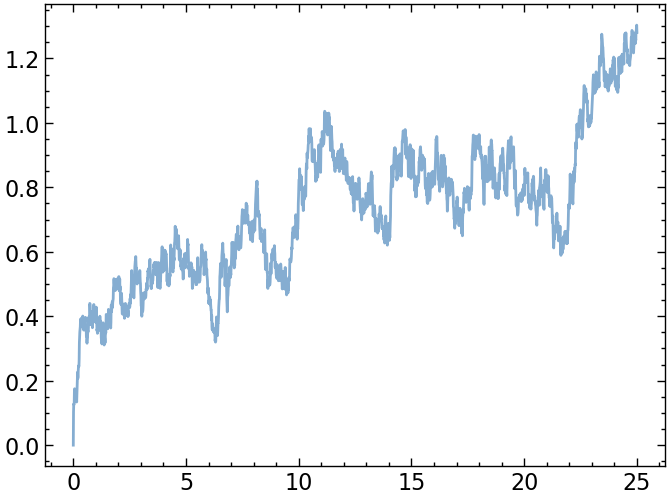

In [10]:
from MDAnalysis.analysis import rms

R = rms.RMSD(colpk_pyc,  # universe to align
    colpk_pyc,  # reference universe or atomgroup
    select='backbone',  # group to superimpose and calculate RMSD
    ref_frame=0)  # frame index of the reference

R.run(verbose=True)
times_c = R.results.rmsd[:,1]
rmsd_c = R.results.rmsd[:,2]
plt.plot(times_c/1000, rmsd_c/10, alpha=0.5)

## Radius of Gyration Calculation

  0%|          | 0/2501 [00:00<?, ?it/s]

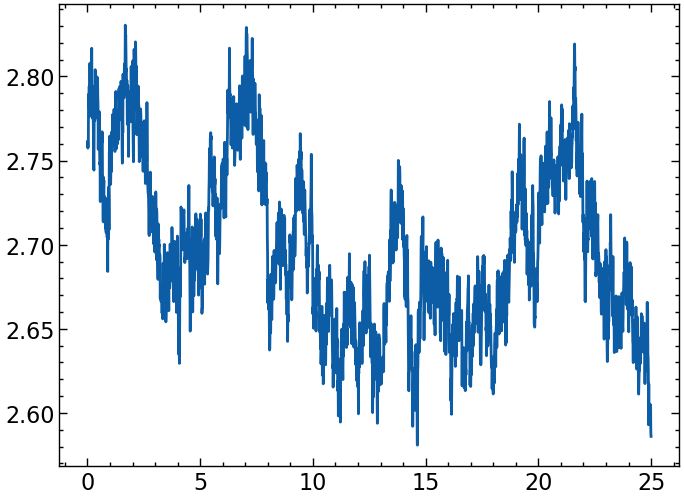

In [11]:
from tqdm.notebook import tqdm
group = colpk_pyc.select_atoms('protein')		# change the atom selection for your specific system

Frame = []
times = []
Rgyr = []
for ts in tqdm(colpk_pyc.trajectory):
	Frame.append(ts.frame)
	times.append(colpk_pyc.trajectory.time)
	Rgyr.append(group.radius_of_gyration())

Rgyrc_table = np.vstack((Frame, times, Rgyr)).T
plt.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10)

## RMSF Calculation

Between protein backbone and Carbon alphas.

  0%|          | 0/2501 [00:00<?, ?it/s]

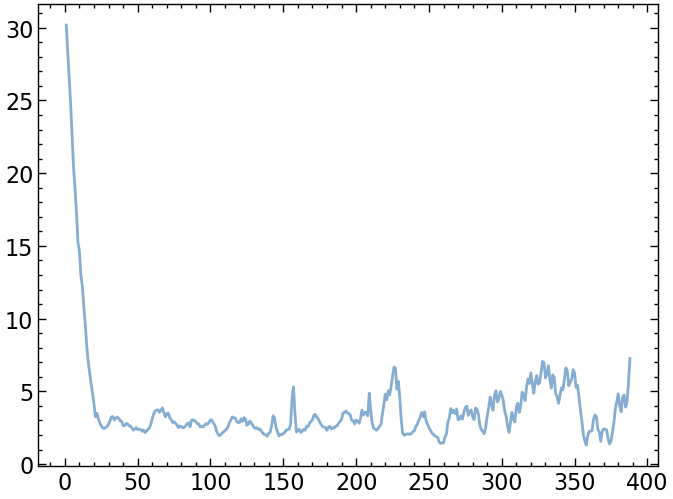

In [16]:
c_alphas_c = colpk_pyc.select_atoms('backbone and name CA')
R_c = rms.RMSF(c_alphas_c).run(verbose=True)
plt.plot(c_alphas_c.resids, R_c.results.rmsf, alpha=0.5)

### Observations

Rapid changes in radius of gyration, together with high RMSF in the first few residues of the protein suggest conformational changes in the tail end of the chain. Might need `DSSP` for further analysis.

## H-bond analysis:

**Note:** As of today (20241222), the latest version of MDAnalysis (2.8) cannot read binary topology files (the ones with the `.tpr` extension) created by gromacs version 2024.4. Binary topology data is necessary for hydrogen bond analysis in `MDAnalysis` for some reason, so I am trying `MDTraj` instead.


In `MDTraj`, the Baker-Hubbard Hydrogen Bond Identification can be used, where the hydrogen bond is said to have formed if:

1. The angle $\theta_{dha}>2\pi/3$, *i.e.*, $120$ degrees, and
2. The distance $r_{ha}<0.25\;nm$. 
   
Here, $d$ means 'donor', 'h' means 'hydrogen', and 'a' means acceptor.
The donors considered by this method are NH and OH, and the acceptors considered are O and N.

Do not load the whole trajectory, as it will take up too much memory. Unlike `MDAnalysis`, `MDTraj` doesn't do lazy loads from disk, but fully operates in memory. This makes it faster, but memory-intensive.

So, we choose a 'stride' of, say, $60$ frames, and have `MDTraj` load every $60^{th}$ frame of the trajectory, then run the baker-hubbard algorithm.

In [12]:
stride = 3
total_frames = 2500
total_time_ns = 25

timestep  = (stride/total_frames) * total_time_ns

nframes = int(np.ceil(total_frames/stride))

timestep, nframes

(0.03, 834)

In [13]:
#%%time
import numpy as np
import mdtraj as md


topfile='colpk_pyc_charmm/sys_prod/start.pdb'
xtcfile='colpk_pyc_charmm/sys_prod/prod_colpk_pyc_charmm_compact_compact.xtc'

full_traj = md.load_xtc(xtcfile, stride=stride, top=topfile)
pyc_atoms = full_traj.topology.select('resname PYC')
hbonds = md.baker_hubbard(full_traj, periodic=False, freq=0.01)
label = lambda hbond : '%s - %s ... %s' % ( full_traj.topology.atom(hbond[0]),\
                                            full_traj.topology.atom(hbond[1]),\
                                            full_traj.topology.atom(hbond[2]))
pyc_hbonds = []
for hbond in hbonds:
    d,h,a = hbond
    if d in pyc_atoms or a in pyc_atoms:
        pyc_hbonds.append(hbond)
        print(label(hbond))

pyc_hbonds = np.array(pyc_hbonds)

In [14]:
pyc_hbonds

array([], dtype=float64)

In [15]:
np.unique(hbonds, axis=0).shape

(913, 3)

So, according to `MDTraj` Baker-Hubbard hbond detector, there are **NO** hydrogen bonds betweek protein and  that form at more than a frequency of `freq=` $0.01$ in the trajectory frames. This is consistent with the video from `VMD.`

**However**, a whole bunch of hbonds are being detected within the protein ($913$, to be exact). These may need further analysis.

## Plots

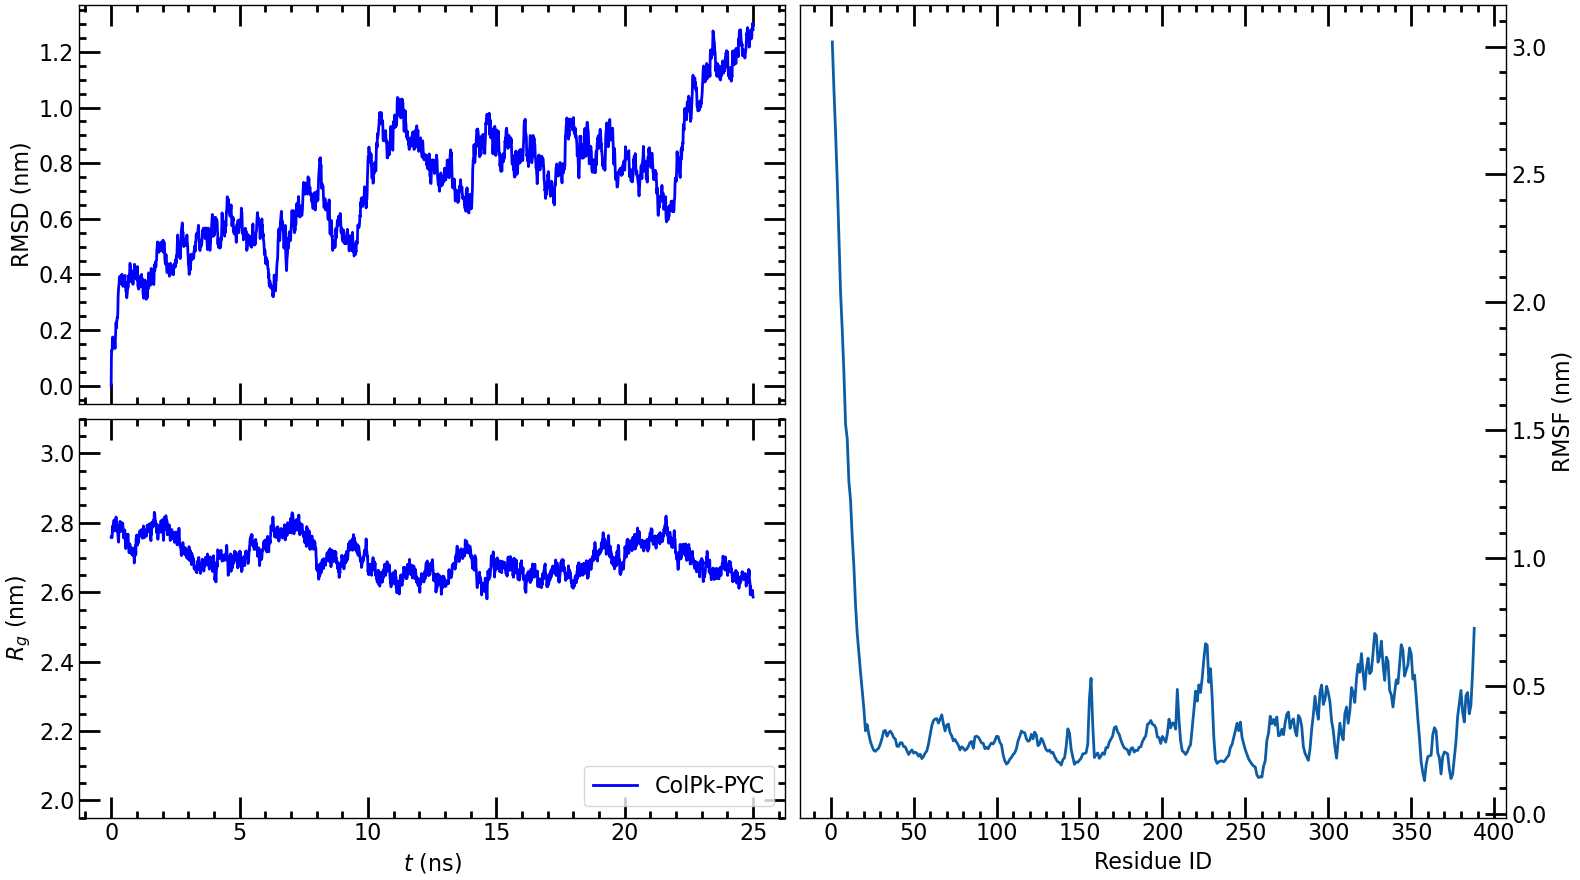

In [18]:
plt.style.use(['science','notebook'])
fig, axs = plt.subplots(2,2,figsize=(16,9), sharex=True, tight_layout=True)

ax_rmsd = axs[0,0]
ax_rmsd.set_ylabel(r'RMSD (nm)');


ax_rmsd.plot(times_c/1000, rmsd_c/10, label="ColPk-PYC", 
        color='blue')


ax_rg = axs[1,0]

ax_rg.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10, 
        label="ColPk-PYC", color='blue')
ax_rg.set_ylabel(r'$R_g$ (nm)')
ax_rg.set_xlabel(r'$t$ (ns)');
ax_rg.set_ylim(1.95,3.1)

# Remove the second row, second column subplot 
fig.delaxes(axs[1, 1]) # Merge the first row, second column subplot to cover the two positions 
axs[0, 1].remove() 
ax_rmsf = fig.add_subplot(2, 2, (2, 4))
ax_rmsf.plot(c_alphas_c.resids, R_c.results.rmsf/10)
ax_rmsf.set_xlabel("Residue ID")
# Shift the y-axis to the right 
ax_rmsf.yaxis.set_label_position("right") 
ax_rmsf.yaxis.tick_right()
ax_rmsf.set_ylabel("RMSF (nm)")


ax_rg.legend(loc="lower right", frameon=True) 

# Function to make ticks twice as big 
def set_ticks_bigger(ax): 
    ax.tick_params(axis='both', which='major', length=15, width=2) # Major ticks 
    ax.tick_params(axis='both', which='minor', length=5, width=2) # Minor ticks 
    
# Apply the tick size change to all axes 
for ax in [ax_rmsd, ax_rmsf, ax_rg]: 
    set_ticks_bigger(ax)


plt.savefig("time-series-plots_charmm.png", dpi=600)
plt.show()